# Hotel Reviews Sentiment Analysis
The data set is the [Deceptive Opinion Spam Corpus v1.4]("http://myleott.com/op-spam.html")

In [1]:
import os
import pandas as pd
import regex as re
import operator
import fnmatch
import pickle
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk import pos_tag,pos_tag_sents

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split  
from sklearn import metrics
from sklearn import svm
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

/home/hvyd/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/hvyd/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[nltk_data] Downloading package stopwords to /home/hvyd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hvyd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hvyd/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data import and Processing

In [2]:
path = 'data/op_spam_v1.4/'

label = []

configfiles = [os.path.join(subdir,f)
for subdir, dirs, files in os.walk(path)
    for f in fnmatch.filter(files, '*.txt')]

In [3]:
print('Number of Files in DataSet: ',len(configfiles))
print("TEST file print:", configfiles[42])

Number of Files in DataSet:  1600
TEST file print: data/op_spam_v1.4/positive_polarity/truthful_from_TripAdvisor/fold2/t_ambassador_10.txt


In [4]:
for f in configfiles:
    c = re.search('(trut|deceptiv)\w',f)
    label.append(c.group())

In [5]:
labels = pd.DataFrame(label, columns = ['Labels'])
labels.head()

,Labels
0,truth
1,truth
2,truth
3,truth
4,truth


In [6]:
review = []
directory =os.path.join("data/op_spam_v1.4/")
for subdir,dirs ,files in os.walk(directory):
   # print (subdir)
    for file in files:
        if fnmatch.filter(files, '*.txt'):
            f=open(os.path.join(subdir, file),'r')
            a = f.read()
            review.append(a)

In [7]:
reviews = pd.DataFrame(review, columns = ['HotelReviews'])
reviews.head()

,HotelReviews
0,Ambassador East is an awesome hotel!!! Underst...
1,This hotel was PERFECT for our girls getaway. ...
2,Stayed at the Chicago Affinia Dec 10 thru Dec ...
3,Stayed at this hotel with 3 friends or 4 night...
4,We live down the block from the hotel. We arra...


In [8]:
result = pd.merge(reviews, labels,right_index=True,left_index = True)
result['HotelReviews'] = result['HotelReviews'].map(lambda x: x.lower())
result.head()

,HotelReviews,Labels
0,ambassador east is an awesome hotel!!! underst...,truth
1,this hotel was perfect for our girls getaway. ...,truth
2,stayed at the chicago affinia dec 10 thru dec ...,truth
3,stayed at this hotel with 3 friends or 4 night...,truth
4,we live down the block from the hotel. we arra...,truth


In [9]:
stop = stopwords.words('english')
result['review_without_stopwords'] = result['HotelReviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
result.head()

,HotelReviews,Labels,review_without_stopwords
0,ambassador east is an awesome hotel!!! underst...,truth,ambassador east awesome hotel!!! understand ho...
1,this hotel was perfect for our girls getaway. ...,truth,hotel perfect girls getaway. decor fun & refre...
2,stayed at the chicago affinia dec 10 thru dec ...,truth,stayed chicago affinia dec 10 thru dec 12 impr...
3,stayed at this hotel with 3 friends or 4 night...,truth,stayed hotel 3 friends 4 nights. hotel clean t...
4,we live down the block from the hotel. we arra...,truth,live block hotel. arranged new floors put cond...


In [10]:
def pos(review_without_stopwords):
    return TextBlob(review_without_stopwords).tags

In [11]:
os = result.review_without_stopwords.apply(pos)
os1 = pd.DataFrame(os)
os1.head()

,review_without_stopwords
0,"[(ambassador, NN), (east, JJ), (awesome, JJ), ..."
1,"[(hotel, NN), (perfect, JJ), (girls, NNS), (ge..."
2,"[(stayed, VBN), (chicago, NN), (affinia, NN), ..."
3,"[(stayed, JJ), (hotel, NN), (3, CD), (friends,..."
4,"[(live, JJ), (block, NN), (hotel, NN), (arrang..."


In [12]:
os1['pos'] = os1['review_without_stopwords'].map(lambda x:" ".join(["/".join(x) for x in x ]) )
result = result = pd.merge(result, os1,right_index=True,left_index = True)
result.head()

,HotelReviews,Labels,review_without_stopwords_x,review_without_stopwords_y,pos
0,ambassador east is an awesome hotel!!! underst...,truth,ambassador east awesome hotel!!! understand ho...,"[(ambassador, NN), (east, JJ), (awesome, JJ), ...",ambassador/NN east/JJ awesome/JJ hotel/NN unde...
1,this hotel was perfect for our girls getaway. ...,truth,hotel perfect girls getaway. decor fun & refre...,"[(hotel, NN), (perfect, JJ), (girls, NNS), (ge...",hotel/NN perfect/JJ girls/NNS getaway/RB decor...
2,stayed at the chicago affinia dec 10 thru dec ...,truth,stayed chicago affinia dec 10 thru dec 12 impr...,"[(stayed, VBN), (chicago, NN), (affinia, NN), ...",stayed/VBN chicago/NN affinia/NN dec/NN 10/CD ...
3,stayed at this hotel with 3 friends or 4 night...,truth,stayed hotel 3 friends 4 nights. hotel clean t...,"[(stayed, JJ), (hotel, NN), (3, CD), (friends,...",stayed/JJ hotel/NN 3/CD friends/NNS 4/CD night...
4,we live down the block from the hotel. we arra...,truth,live block hotel. arranged new floors put cond...,"[(live, JJ), (block, NN), (hotel, NN), (arrang...",live/JJ block/NN hotel/NN arranged/VBN new/JJ ...


# Training and Predicting The Data

In [13]:
review_train, review_test, label_train, label_test = train_test_split(result['pos'],result['Labels'], test_size=0.2,random_state=13)
tf_vect = TfidfVectorizer(lowercase = True, use_idf=True, smooth_idf=True, sublinear_tf=False)

X_train_tf = tf_vect.fit_transform(review_train)
X_test_tf = tf_vect.transform(review_test)

In [14]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [15]:
svc_param_selection(X_train_tf,label_train,5)

{'C': 1, 'gamma': 0.001}

In [16]:
clf = svm.SVC(C=10,gamma=0.001,kernel='linear')
clf.fit(X_train_tf,label_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
pred = clf.predict(X_test_tf)

In [18]:
with open('vectorizer.pickle', 'wb') as fin:
    pickle.dump(tf_vect, fin)

In [19]:
with open('mlmodel.pickle','wb') as f:
    pickle.dump(clf,f)

In [20]:
pkl = open('mlmodel.pickle', 'rb')
clf = pickle.load(pkl)   
vec = open('vectorizer.pickle', 'rb')
tf_vect = pickle.load(vec)

In [21]:
X_test_tf = tf_vect.transform(review_test)
pred = clf.predict(X_test_tf)

In [22]:
print (confusion_matrix(label_test, pred))

[[145  20]
 [ 25 130]]


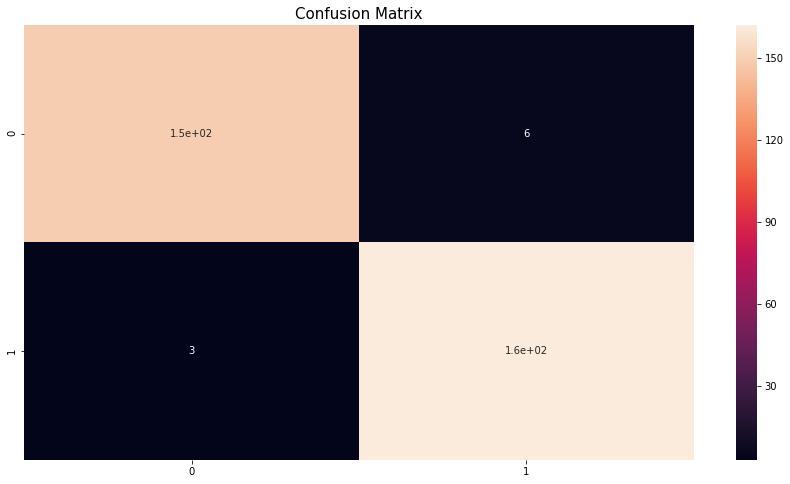

0.971875
             precision    recall  f1-score   support

  deceptive       0.96      0.98      0.97       152
      truth       0.98      0.96      0.97       168

avg / total       0.97      0.97      0.97       320



In [28]:
cm=confusion_matrix(pred,label_test)
f,ax=plt.subplots(figsize=(15,8))
sns.heatmap(cm,annot=True,ax=ax)
ax.set_title("Confusion Matrix",fontsize=15)
plt.show()

print(metrics.accuracy_score(label_test, pred))
print (classification_report(label_test, pred))

# Test Model

In [23]:
review_train, review_test, label_train, label_test = train_test_split(result['pos'],result['Labels'], test_size=0.2,random_state=42)
X_test_tf = tf_vect.transform(review_test)
pred = clf.predict(X_test_tf)

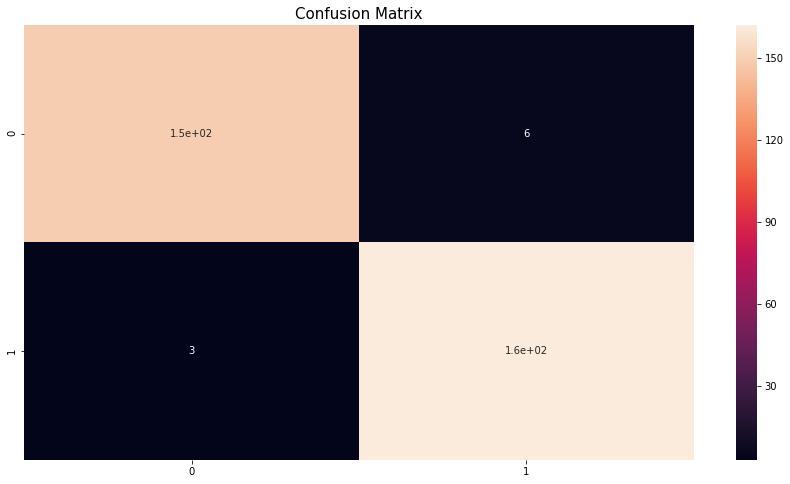

0.971875
             precision    recall  f1-score   support

  deceptive       0.96      0.98      0.97       152
      truth       0.98      0.96      0.97       168

avg / total       0.97      0.97      0.97       320



In [24]:
cm=confusion_matrix(pred,label_test)
f,ax=plt.subplots(figsize=(15,8))
sns.heatmap(cm,annot=True,ax=ax)
ax.set_title("Confusion Matrix",fontsize=15)
plt.show()

print(metrics.accuracy_score(label_test, pred))
print (classification_report(label_test, pred))

In [25]:
def test_string(s):
    X_test_tf = tf_vect.transform([s])
    y_predict = clf.predict(X_test_tf)
    return y_predict

In [26]:
test_string("The hotel was good.The room had a 27-inch Samsung led tv, a microwave.The room had a double bed")

array(['truth'], dtype=object)

In [27]:
test_string("My family and I are huge fans of this place. The staff is super nice, and the food is great. The chicken is very good, and the garlic sauce is perfect. Ice cream topped with fruit is delicious too. Highly recommended!")

array(['truth'], dtype=object)